# Prediction of car prices based on their condition


![image](https://storage.googleapis.com/kaggle-datasets-images/1479517/2444963/1aaa3760e7dd34a87af175482c1514ae/dataset-cover.jpg?t=2021-07-21-09-56-46)

Data extracted from kaggle. Click [here](https://www.kaggle.com/datasets/sidharth178/car-prices-dataset) to see it.

## Table of Content:
1. [First view to data](#section1)
2. [Select and Train a Models](#section2)

## First view at the data <a id="section1"></a>

In [1]:
import os
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running on Kaggle")
    data_dir = "../input/car-prices-dataset"
else:
    print("Not running on Kaggle")
    data_dir = "archive"

Not running on Kaggle


In [2]:
import numpy as np
import pandas as pd

# We already have the data partitioned
df_train = pd.read_csv(f"{data_dir}/train.csv")
print(f"Shape: {df_train.shape}")
df_train.head()

Shape: (19237, 18)


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df_train.isna().sum() # Below we can see the data is extremely clean; this is not common at all

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [4]:
sorted(df_train["Prod. year"].unique())

[1939,
 1943,
 1947,
 1953,
 1957,
 1964,
 1965,
 1968,
 1973,
 1974,
 1976,
 1977,
 1978,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

In [5]:
import re

def clean(df):
    df = df.copy()
    df["Leather interior"] = df["Leather interior"].apply(lambda x: 1 if x=="Yes" else 0) # Numeric atributes are much easier to manage
    df.drop(["ID", "Levy"], axis=1, inplace=True)
    df["Engine volume"] = df["Engine volume"].apply(lambda x: float(x.split(" ")[0]))
    df["Mileage"] = df["Mileage"].apply(lambda x: float(x.split(" ")[0]))
    df["Doors"] = df["Doors"].apply(lambda x: np.int64(re.findall(r'\d+', x)[0]))
    return df

print("We have a {:.2%} of null levies".format(df_train['Levy'].apply(lambda x: x=='-').sum() / df_train.shape[0]))
print("It is very high, so we won't be using that feature")

df_train = clean(df_train)
df_train.info()

We have a 30.25% of null levies
It is very high, so we won't be using that feature
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Manufacturer      19237 non-null  object 
 2   Model             19237 non-null  object 
 3   Prod. year        19237 non-null  int64  
 4   Category          19237 non-null  object 
 5   Leather interior  19237 non-null  int64  
 6   Fuel type         19237 non-null  object 
 7   Engine volume     19237 non-null  float64
 8   Mileage           19237 non-null  float64
 9   Cylinders         19237 non-null  float64
 10  Gear box type     19237 non-null  object 
 11  Drive wheels      19237 non-null  object 
 12  Doors             19237 non-null  int64  
 13  Wheel             19237 non-null  object 
 14  Color             19237 non-null  object 
 15  Airb

In [6]:
df_train.describe()

,Price,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Doors,Airbags
count,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,1.855593e+04,2010.912824,0.725373,2.307990,1.532236e+06,4.582991,3.925872,6.582627
std,1.905813e+05,5.668673,0.446338,0.877805,4.840387e+07,1.199933,0.403399,4.320168
min,1.000000e+00,1939.000000,0.000000,0.000000,0.000000e+00,1.000000,2.000000,0.000000
25%,5.331000e+03,2009.000000,0.000000,1.800000,7.013900e+04,4.000000,4.000000,4.000000
50%,1.317200e+04,2012.000000,1.000000,2.000000,1.260000e+05,4.000000,4.000000,6.000000
75%,2.207500e+04,2015.000000,1.000000,2.500000,1.888880e+05,4.000000,4.000000,12.000000
max,2.630750e+07,2020.000000,1.000000,20.000000,2.147484e+09,16.000000,5.000000,16.000000


In [7]:
import matplotlib.pyplot as plt

Y = df_train.select_dtypes(include = ["float64", "int64"])

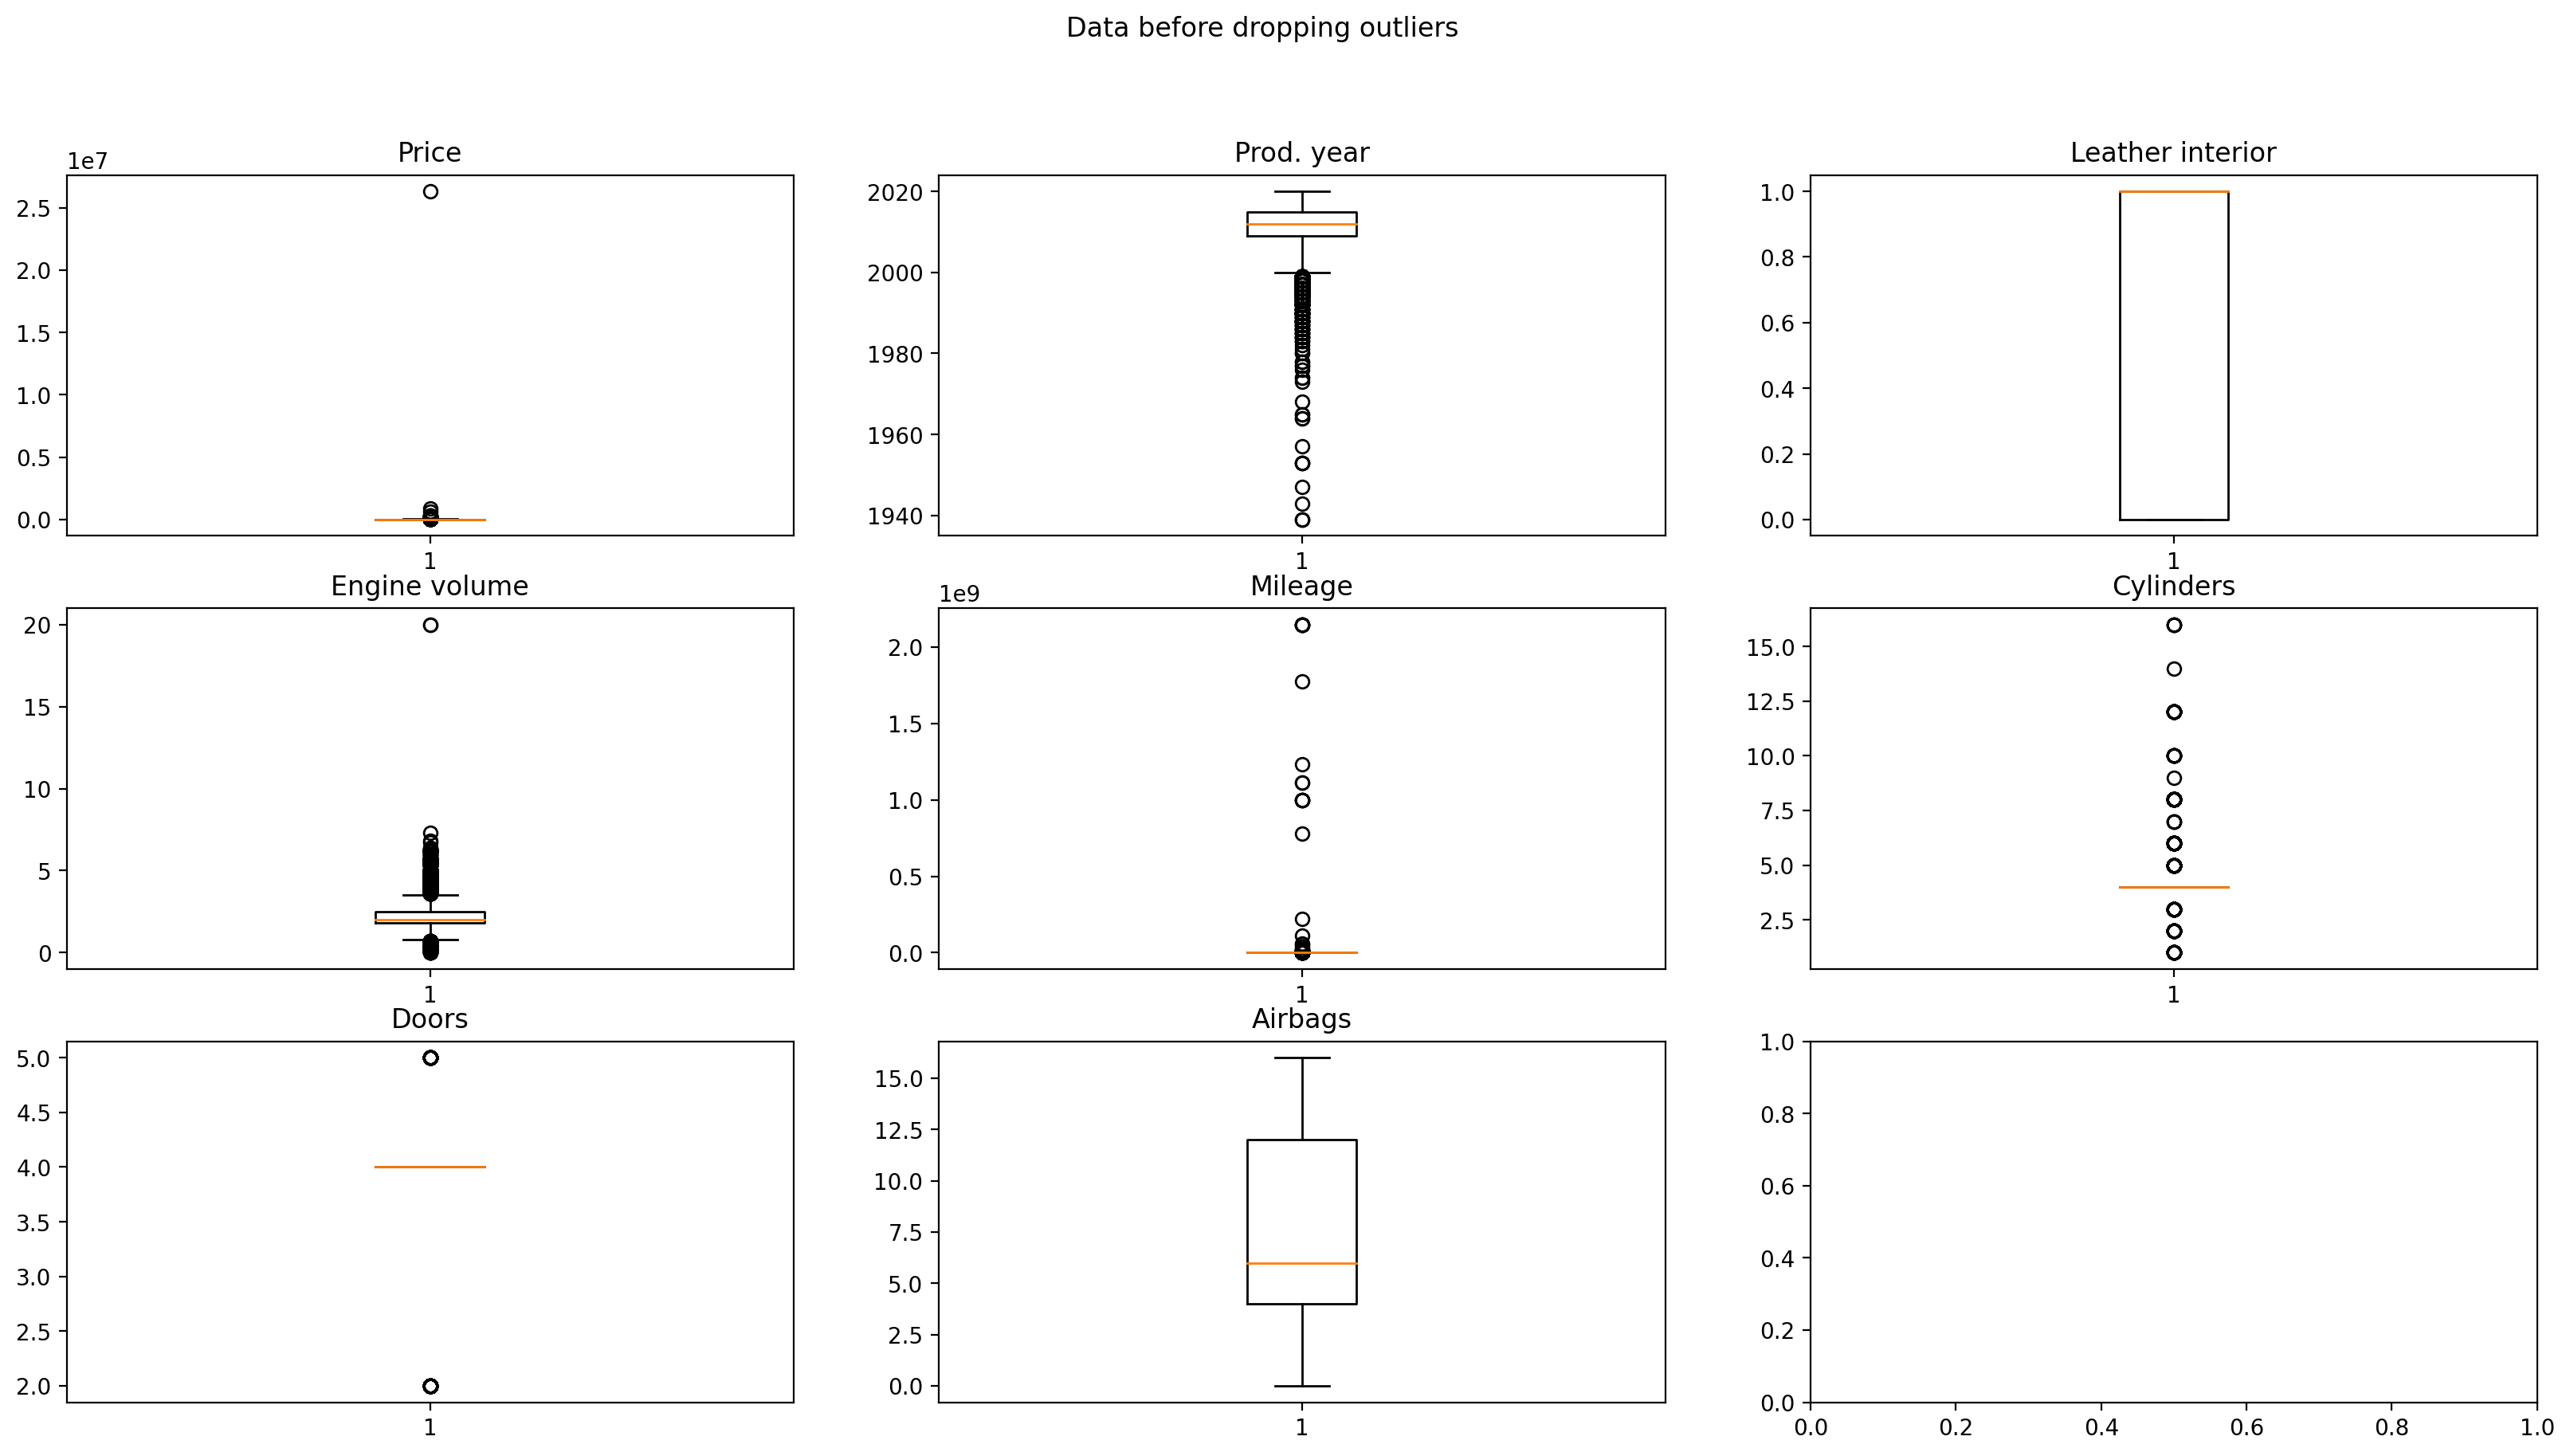

In [8]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Data before dropping outliers")
fig.set_dpi(200)
fig.set_size_inches(20, 10)
for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].boxplot(Y[column])
    axs[int(index/3)][index%3].set_title(column)

## Preprocessing

We can appreciate various outliers in *Price*, *Engine Volume* and a few more. Let's drop them

In [9]:
for column in ["Price", "Prod. year", "Engine volume", "Mileage"]:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(df_train[column]>=upper)[0]
    lower_array = np.where(df_train[column]<=lower)[0]
    
    # Removing the outliers
    df_train.drop(index=upper_array, inplace=True)
    df_train.drop(index=lower_array, inplace=True)
    df_train.reset_index(inplace=True, drop=True)

Y = df_train.select_dtypes(include = ["float64", "int64"])

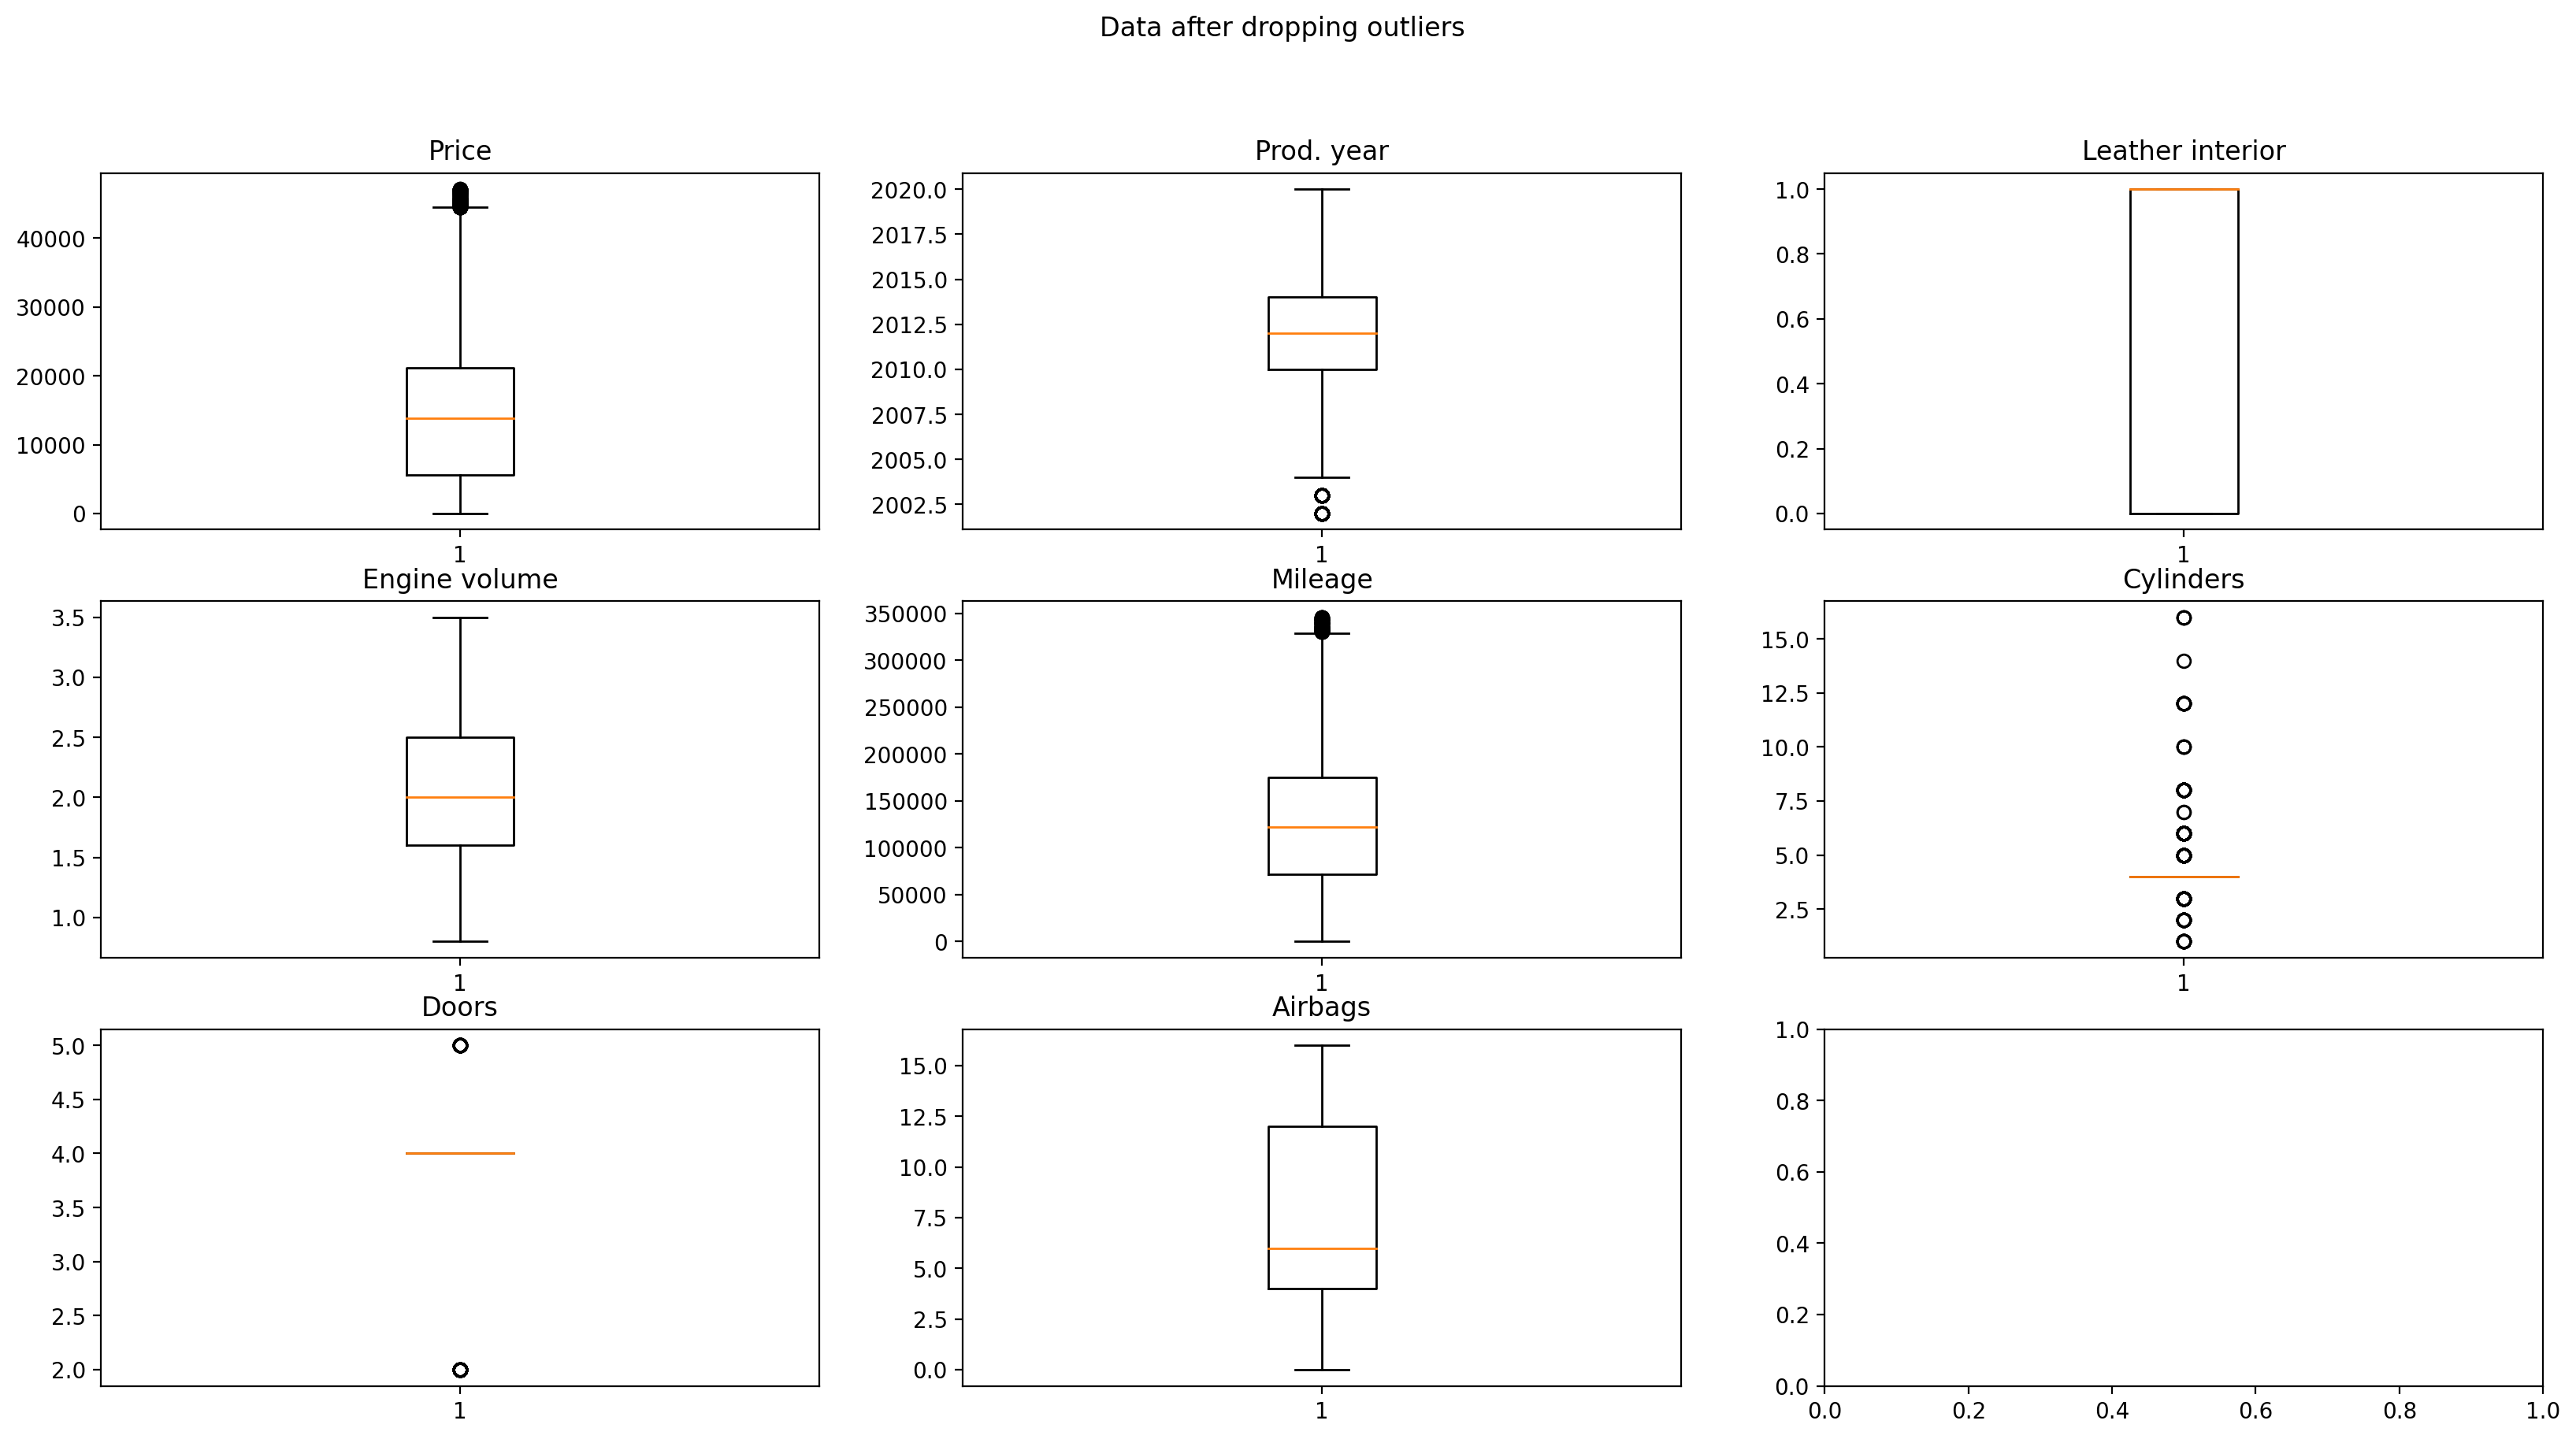

In [10]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Data after dropping outliers")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].boxplot(Y[column])
    axs[int(index/3)][index%3].set_title(column)

This already looks like a much cleaner dataset. We could drop a lot of data that seems to be outlier, but we'll use all the data for the moment and worry later

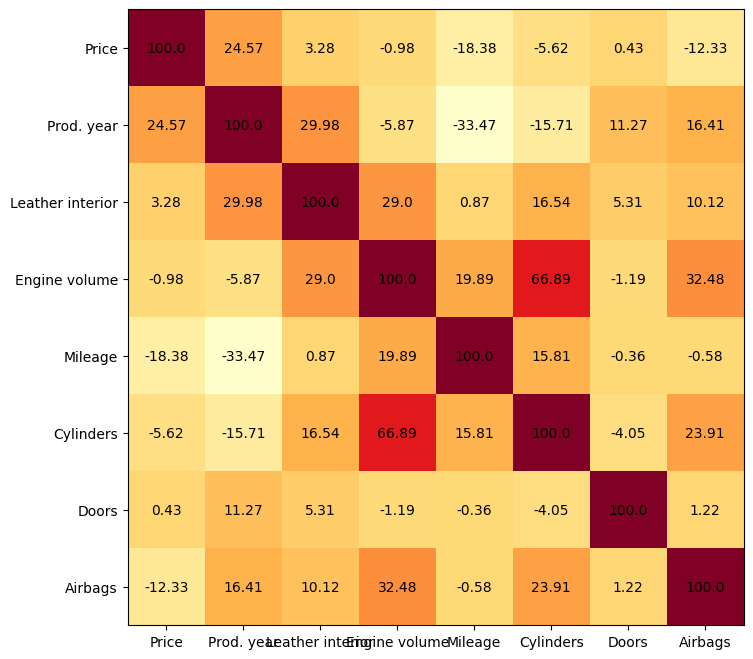

In [11]:
fig, ax = plt.subplots(figsize = (Y.shape[1], Y.shape[1]))
fig = plt.imshow(Y.corr(), cmap = "YlOrRd")
ax.set_xticks(range(Y.shape[1]))
ax.set_xticklabels(Y.axes[1])
ax.set_yticks(range(Y.shape[1]))
ax.set_yticklabels(Y.axes[1])
for (j,i),label in np.ndenumerate((Y.corr()*100).round(2)):
    ax.text(i,j,label,ha='center',va='center')
plt.show()

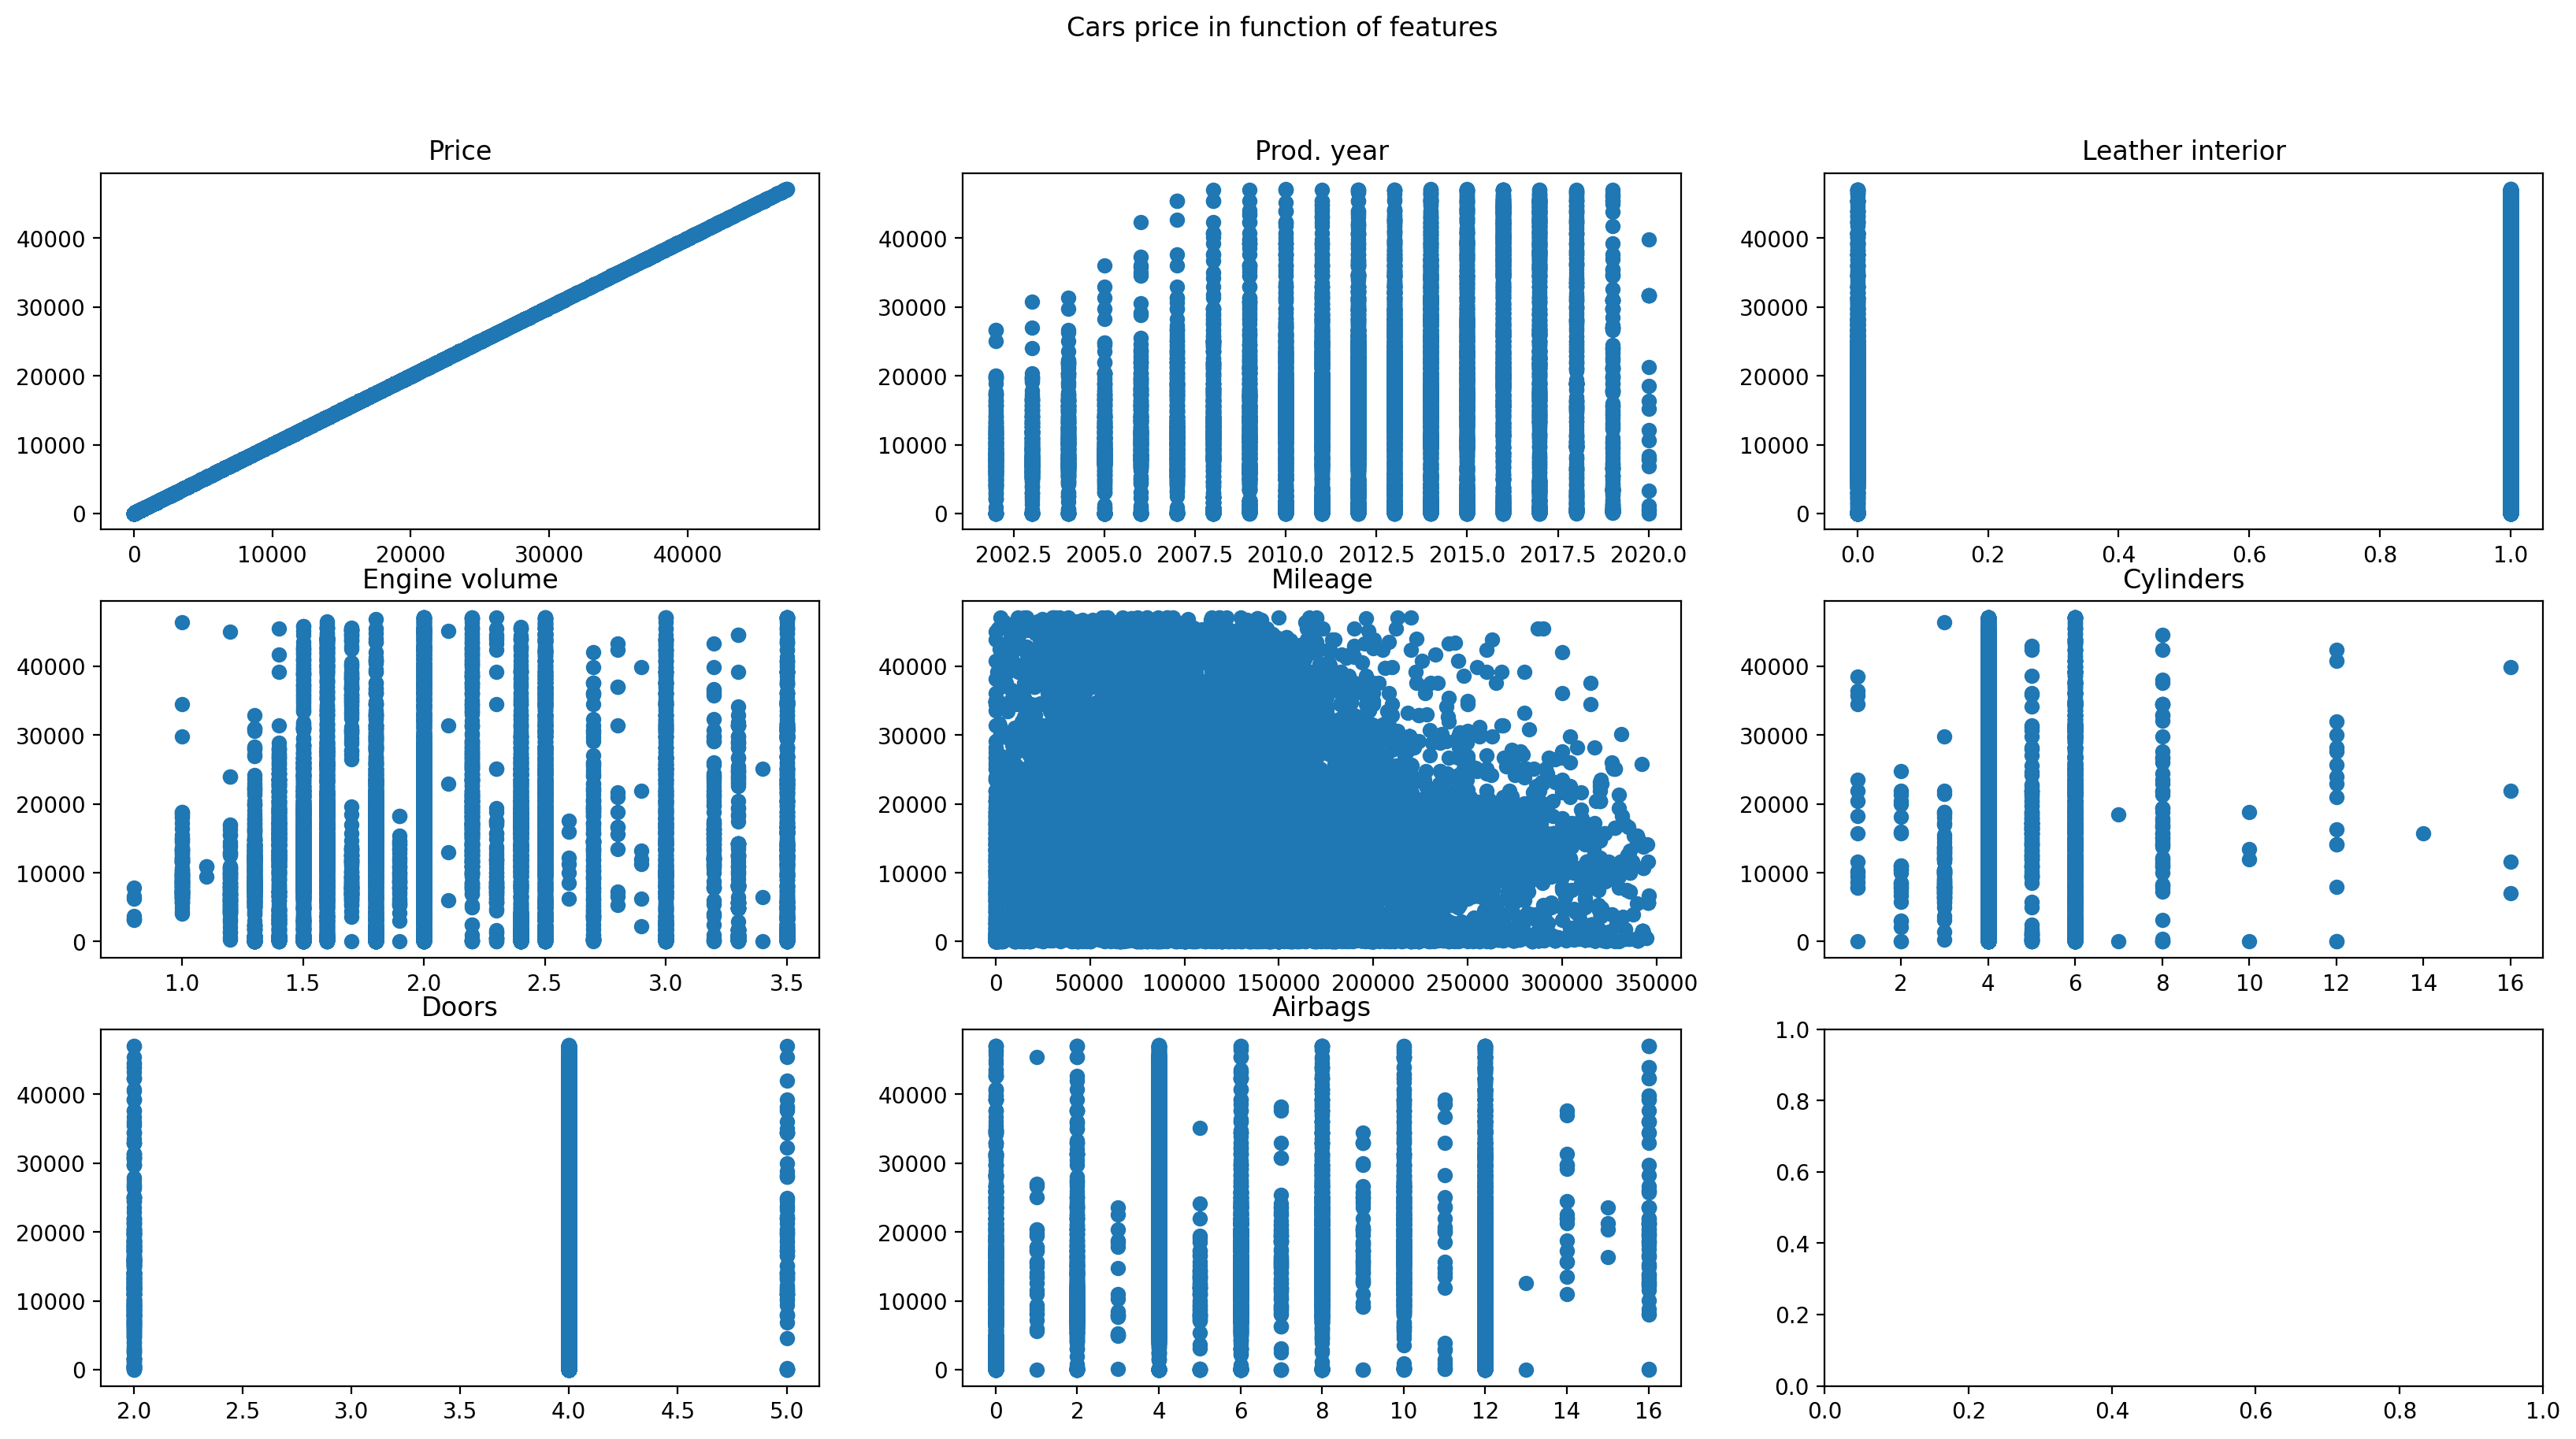

In [12]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Cars price in function of features")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].scatter(Y[column], Y["Price"])
    axs[int(index/3)][index%3].set_title(column)

## Get extra features

This project is aimed at predicting car prices based on a few features. We can get extra features that could help us in the prediction. We'll use the jerarquical KMeans algorithm to get the clusters.

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder

class GetExtraFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dataset = None
        self.knownFeatures = []
        self.unknownFeatures = []
        
    def fit(self, X, y=None):
        self.dataset = X
        self.__assignFeatures__(X.columns)
        return self
    
    def __assignFeatures__(self, columns):
        self.knownFeatures = ["Manufacturer", "Model", "Color", "Prod. year", "Mileage", "Leather interior"]
        self.unknownFeatures = list((set(columns) - set(self.knownFeatures)) - {"Price"})
    
    def transform(self, X):
        newX = pd.DataFrame(columns=self.knownFeatures+self.unknownFeatures)
        for i in range(X.shape[0]):
            carModelInstance = self.dataset[
                (self.dataset["Manufacturer"]==X["Manufacturer"].iloc[i]) & 
                (self.dataset["Model"]==X["Model"].iloc[i])].iloc[0, :]
            

            newRow = pd.Series(index=self.knownFeatures+self.unknownFeatures)
            newRow[self.knownFeatures] = X.iloc[i, :]
            newRow[self.unknownFeatures] = carModelInstance[self.unknownFeatures]

            newX = pd.concat([newX, newRow.to_frame().T], axis=0)
        
        return newX

In [134]:
getter = GetExtraFeatures()
getter.fit(df_train)

knownFeatures = ["Manufacturer", "Model", "Color", "Prod. year", "Mileage", "Leather interior"]
X = df_train[knownFeatures]

getter.transform(X.iloc[:500, :])

,Manufacturer,Model,Color,Prod. year,Mileage,Leather interior,Cylinders,Wheel,Engine volume,Gear box type,Drive wheels,Fuel type,Category,Airbags,Doors
0,LEXUS,RX 450,Silver,2010,186005.0,1,6.0,Left wheel,3.5,Automatic,4x4,Hybrid,Jeep,12,4
0,CHEVROLET,Equinox,Black,2011,192000.0,0,6.0,Left wheel,3.0,Tiptronic,4x4,Petrol,Jeep,8,4
0,HONDA,FIT,Black,2006,200000.0,0,4.0,Right-hand drive,1.3,Variator,Front,Petrol,Hatchback,2,4
0,FORD,Escape,White,2011,168966.0,1,4.0,Left wheel,2.5,Automatic,4x4,Hybrid,Jeep,0,4
0,HONDA,FIT,Silver,2014,91901.0,1,4.0,Right-hand drive,1.3,Variator,Front,Petrol,Hatchback,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HYUNDAI,Sonata,Silver,2011,72000.0,1,4.0,Left wheel,2.4,Automatic,Front,Petrol,Sedan,12,4
0,DAEWOO,Lacetti,Black,2010,46527.0,1,4.0,Left wheel,2.0,Automatic,Front,Petrol,Sedan,4,4
0,TOYOTA,Highlander,Black,2014,166560.0,1,6.0,Left wheel,3.3,Automatic,4x4,Hybrid,Sedan,12,4
0,HONDA,Civic,Blue,2013,87000.0,1,4.0,Left wheel,2.0,Automatic,Front,Petrol,Sedan,4,4


# License

This Jupyter Notebook and its contents are licensed under the terms of the GNU General Public License Version 2 as published by the Free Software Foundation. The full text of the license can be found at: https://www.gnu.org/licenses/gpl-2.0.html

Copyright (c) 2024, Joaquín Mateos Barroso

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see https://www.gnu.org/licenses/ for a list of additional licenses.